In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

import torch
import torch.nn as nn
from utils import *   # 如果不需要可以先保留，里面可能有 open_dataset 等工具

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

sst_path  = "SST_TropicalPacific_1980_2020 (1).nc"
flux_path = "fgco2_TropicalPacific_1980_2020.nc"

# 1) 读取 SST
ds_sst = xr.open_dataset(sst_path)
print(ds_sst)   # 你可以先看一眼变量名

# 把坐标名改成和 fgco2 一样
ds_sst = ds_sst.rename({"latitude": "lat", "longitude": "lon"})
sst = ds_sst["sst"]      # 如果变量不叫 sst，这里改一下

# 2) 读取 fgco2
ds_flux = xr.open_dataset(flux_path)
flux = ds_flux["fgco2"]

print("原始 sst time :", str(sst.time.min().values)[:10],  "→", str(sst.time.max().values)[:10])
print("原始 flux time:", str(flux.time.min().values)[:10], "→", str(flux.time.max().values)[:10])

# 3) 在 time 上取交集（最终都只做到 2018）
t0 = max(sst.time.min(), flux.time.min())
t1 = np.datetime64("2018-12-31")
sst  = sst.sel(time=slice(t0, t1))
flux = flux.sel(time=slice(t0, t1))

print("slice 后 sst time :", str(sst.time.min().values)[:10],  "→", str(sst.time.max().values)[:10])
print("slice 后 flux time:", str(flux.time.min().values)[:10], "→", str(flux.time.max().values)[:10])

# 4) 像 wind 一样：在 time, lat, lon 三个维度上，把 SST 插值到 fgco2 网格
sst_interp = sst.interp(
    time = flux.time,
    lat  = flux.lat,
    lon  = flux.lon
)

print("sst_interp shape:", sst_interp.shape)
print("flux shape      :", flux.shape)

# 5) 合成 Dataset → DataFrame
ds_all = xr.Dataset(
    {
        "sst": sst_interp,
        "fgco2": flux,
    }
)

df_sst = ds_all.to_dataframe().reset_index()
df_sst = df_sst.dropna(subset=["sst", "fgco2"])

print(df_sst.head())
print("Total samples:", df_sst.shape)


Using device: cpu


sh: 1: Syntax error: "(" unexpected


<xarray.Dataset> Size: 19MB
Dimensions:    (time: 492, latitude: 48, longitude: 200)
Coordinates:
  * time       (time) datetime64[ns] 4kB 1980-01-16T12:00:00 ... 2020-12-16T1...
  * latitude   (latitude) float32 192B 23.5 22.5 21.5 20.5 ... -21.5 -22.5 -23.5
  * longitude  (longitude) float32 800B 100.5 101.5 102.5 ... 297.5 298.5 299.5
Data variables:
    sst        (time, latitude, longitude) float32 19MB ...
原始 sst time : 1980-01-16 → 2020-12-16
原始 flux time: 1980-01-15 → 2020-12-15
slice 后 sst time : 1980-01-16 → 2018-12-16
slice 后 flux time: 1980-02-15 → 2018-12-15
sst_interp shape: (467, 48, 200)
flux shape      : (467, 48, 200)
        time   lat    lon        sst     fgco2
0 1980-02-15 -23.5  100.5  24.326971 -0.670731
1 1980-02-15 -23.5  101.5  24.311869 -0.607181
2 1980-02-15 -23.5  102.5  24.319754 -0.523545
3 1980-02-15 -23.5  103.5  24.471025 -0.383561
4 1980-02-15 -23.5  104.5  24.767303 -0.241710
Total samples: (3636529, 5)


In [11]:
df_sst["time"] = pd.to_datetime(df_sst["time"])

train_df = df_sst[(df_sst["time"] >= "1980-01-01") & (df_sst["time"] < "2011-01-01")]
val_df   = df_sst[(df_sst["time"] >= "2011-01-01") & (df_sst["time"] < "2016-01-01")]
test_df  = df_sst[(df_sst["time"] >= "2016-01-01") & (df_sst["time"] <= "2018-12-31")]

print("Train samples:", len(train_df))
print("Val samples:  ", len(val_df))
print("Test samples: ", len(test_df))

feature_cols_sst = ["sst"]

X_train = train_df[feature_cols_sst].values.astype("float32")
y_train = train_df[["fgco2"]].values.astype("float32")

X_val   = val_df[feature_cols_sst].values.astype("float32")
y_val   = val_df[["fgco2"]].values.astype("float32")

X_test  = test_df[feature_cols_sst].values.astype("float32")
y_test  = test_df[["fgco2"]].values.astype("float32")

print("X_train / y_train:", X_train.shape, y_train.shape)
print("X_val   / y_val  :", X_val.shape,   y_val.shape)
print("X_test  / y_test :", X_test.shape,  y_test.shape)


Train samples: 2888977
Val samples:   467220
Test samples:  280332
X_train / y_train: (2888977, 1) (2888977, 1)
X_val   / y_val  : (467220, 1) (467220, 1)
X_test  / y_test : (280332, 1) (280332, 1)


In [13]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

scaler_sst = StandardScaler()
X_train_s = scaler_sst.fit_transform(X_train)
X_val_s   = scaler_sst.transform(X_val)
X_test_s  = scaler_sst.transform(X_test)

X_train_t = torch.from_numpy(X_train_s)
y_train_t = torch.from_numpy(y_train)

X_val_t   = torch.from_numpy(X_val_s)
y_val_t   = torch.from_numpy(y_val)

X_test_t  = torch.from_numpy(X_test_s)
y_test_t  = torch.from_numpy(y_test)

batch_size = 2048

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)


In [14]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
scaler_sst = StandardScaler()
X_train_s = scaler_sst.fit_transform(X_train)
X_val_s   = scaler_sst.transform(X_val)
X_test_s  = scaler_sst.transform(X_test)

X_train_t = torch.from_numpy(X_train_s)
y_train_t = torch.from_numpy(y_train)

X_val_t   = torch.from_numpy(X_val_s)
y_val_t   = torch.from_numpy(y_val)

X_test_t  = torch.from_numpy(X_test_s)
y_test_t  = torch.from_numpy(y_test)

batch_size = 2048

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)


In [15]:
class SST_MLP(nn.Module):
    def __init__(self, in_dim=1, hidden1=32, hidden2=16, out_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, out_dim),
        )

    def forward(self, x):
        return self.net(x)

model_sst = SST_MLP(in_dim=len(feature_cols_sst)).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_sst.parameters(), lr=1e-3)

model_sst


SST_MLP(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [18]:
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # ---- Train ----
    model_sst.train()
    batch_train_losses = []

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        pred = model_sst(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

        batch_train_losses.append(loss.item())

    train_loss = np.mean(batch_train_losses)

    # ---- Validation ----
    model_sst.eval()
    batch_val_losses = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model_sst(xb)
            loss = criterion(pred, yb)
            batch_val_losses.append(loss.item())

    val_loss = np.mean(batch_val_losses)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (epoch + 1) % 5 == 0:
        print(f"[SST] Epoch {epoch+1:03d} | train={train_loss:.4e} | val={val_loss:.4e}")


[SST] Epoch 005 | train=1.4790e+00 | val=1.7902e+00
[SST] Epoch 010 | train=1.4777e+00 | val=1.7831e+00
[SST] Epoch 015 | train=1.4771e+00 | val=1.7827e+00
[SST] Epoch 020 | train=1.4767e+00 | val=1.7835e+00
[SST] Epoch 025 | train=1.4766e+00 | val=1.7833e+00
[SST] Epoch 030 | train=1.4765e+00 | val=1.7846e+00
[SST] Epoch 035 | train=1.4766e+00 | val=1.7831e+00
[SST] Epoch 040 | train=1.4765e+00 | val=1.7845e+00
[SST] Epoch 045 | train=1.4764e+00 | val=1.7824e+00
[SST] Epoch 050 | train=1.4765e+00 | val=1.7881e+00


In [19]:
from sklearn.metrics import mean_squared_error, r2_score

model_sst.eval()
with torch.no_grad():
    y_pred_test = model_sst(X_test_t.to(device)).cpu().numpy()

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2   = r2_score(y_test, y_pred_test)

print("SST-only, Test period 2016–2018")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²   : {r2:.4f}")

SST-only, Test period 2016–2018
Test RMSE: 1.2930
Test R²   : 0.0168


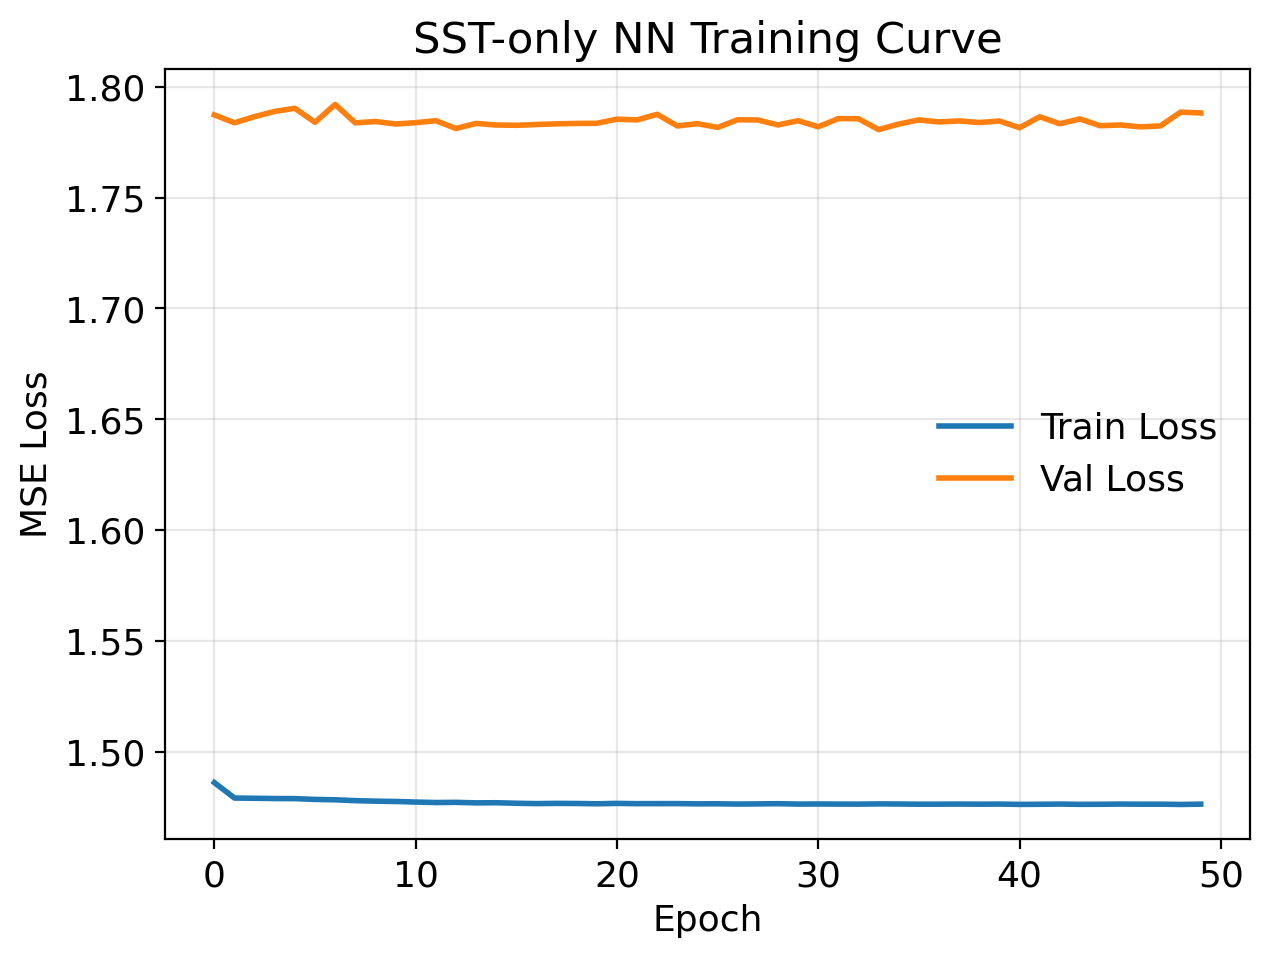

In [20]:
# ========== Plot Train/Val Loss ==========
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train Loss", linewidth=2)
plt.plot(val_losses, label="Val Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("SST-only NN Training Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()